<a href="https://colab.research.google.com/github/Lohitha-Vanteru/Bike-Share-Rebalancing-Project/blob/main/reinforcement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Linear or Random?: linear
Creating A Bike Station Environment!!!
Creating an Agent !!!
Start training the Agent !!!
0 of 2 Session | Episode: 0 | Final count: -49 |Final Reward: -367.50
0 of 2 Session | Episode: 1 | Final count: -59 |Final Reward: -502.50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 10 + 1) instead
  del sys.path[0]


0 of 2 Session | Episode: 2 | Final count: -14 |Final Reward: -217.50
0 of 2 Session | Episode: 3 | Final count: -59 |Final Reward: -385.00
0 of 2 Session | Episode: 4 | Final count: -34 |Final Reward: -322.50
0 of 2 Session | Episode: 5 | Final count: -24 |Final Reward: -310.00
0 of 2 Session | Episode: 6 | Final count: -54 |Final Reward: -410.00
0 of 2 Session | Episode: 7 | Final count: -9 |Final Reward: -140.00
0 of 2 Session | Episode: 8 | Final count: -74 |Final Reward: -415.00
0 of 2 Session | Episode: 9 | Final count: -39 |Final Reward: -330.00
0 of 2 Session | Episode: 10 | Final count: -24 |Final Reward: -300.00
0 of 2 Session | Episode: 11 | Final count: -54 |Final Reward: -440.00
0 of 2 Session | Episode: 12 | Final count: -34 |Final Reward: -362.50
0 of 2 Session | Episode: 13 | Final count: -44 |Final Reward: -365.00
0 of 2 Session | Episode: 14 | Final count: 1 |Final Reward: -222.50
0 of 2 Session | Episode: 15 | Final count: -9 |Final Reward: -120.00
0 of 2 Session | E

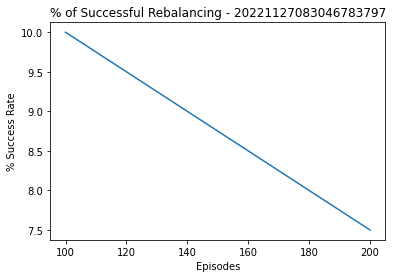

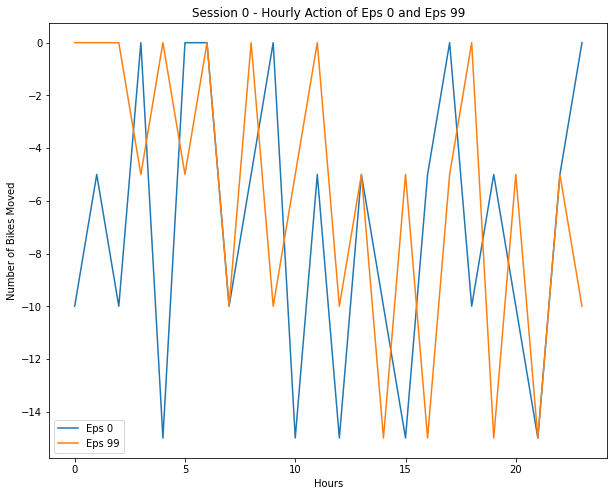

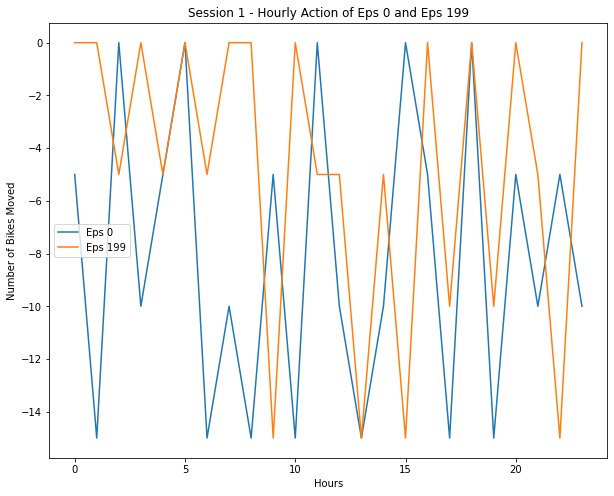

In [14]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import json

class bikestation():
    
    def __init__(self, mode, debug):    
        print("Creating A Bike Station Environment!!!")
        self.mode = mode
        self.seed = np.random.random_integers(0, 10)
        self.num_hours = 23
        self.current_hour = 0
        self.bike_count_sim = self.generate_count(mode)
        self.bike_count = self.bike_count_sim.copy() # to be reset to original copy every episode
        self.old_count = self.bike_count[0]
        self.new_count = 0
        self.done = False
        self.reward = 0
        self.bike_moved = 0
        self.debug = debug
        self.actions = [-15, -10, -5, 0]
        self.n_actions = len(self.actions)
        #features of the observation: hour, old count, new count
        self.n_features = 1
        self.game_over = False
        if self.debug == True:
            print("Generating Bike count: {}".format(self.mode))
            print("Bike count: {}".format(self.bike_count))
        
    def generate_count(self, mode):
        # generate a list of 24 hourly bike count based on mode
        # mode: linear, random, real based on citiBike Data
        bike_count = [50]
        if mode == "linear":
            for i in range(1, 24):
                bike_count.append(bike_count[i-1]+3)
        if mode == "random":
            for i in range(1, 24):
                bike_count.append(bike_count[i-1] + 3 + np.random.random_integers(-5, 5))
        return bike_count

    def feedback(self, action):
        # share back t+1 count, reward of t, and termination status
        if self.debug == True:
            print("Current Hour: {}".format(self.current_hour))
            print("Current count: {}".format(self.bike_count[self.current_hour]))
            print("Bikes Moved in Last Hour: {}".format(self.bike_moved))
            print("Collect {} rewards".format(self.reward))
            print("Will move {} bikes".format(action))
            print("---")
        if action != 0:
            self.update_count(action)
            self.reward = -0.5*np.abs(action)
        if self.bike_count[self.current_hour] > 100:
            self.reward = -30
        if self.bike_count[self.current_hour] < 0:
            self.reward = -30
        if self.current_hour == 23:
            if (self.bike_count[self.current_hour] <= 100)&(self.bike_count[self.current_hour] > 0):
                self.reward = 20
            else: 
                self.reward = -20
            self.done = True
            #self.new_count = 'terminal'
            self.game_over = True
        # update to next hour
        if self.current_hour != 23:
            self.update_hour()
            self.old_count = self.bike_count[self.current_hour - 1]
            self.new_count = self.bike_count[self.current_hour]
        return self.current_hour, self.old_count, self.new_count, self.reward, self.done, self.game_over
    
    def get_old_count(self):
        return self.old_count
    
    def update_count(self, num_bike):
        # update bike count based on RL Agent action at t
        if self.current_hour != 23:
            for hour in range(self.current_hour+1, len(self.bike_count)):
                self.bike_count[hour] += num_bike
            self.bike_moved = num_bike
        else:
            if self.debug == True:
                print("Last Hour!!! Can't Move Bikes Further!!!")
            pass
        return
    
    def update_hour(self):
        # update current_hour 
        self.current_hour += 1
        if self.debug == True:
            print("Forwarding to Current Hour")
        return
    
    def reset(self):
        if self.debug == True:
            print("Resetting The Environment ...")
        self.num_hours = 23
        self.current_hour = 0
        self.bike_count = self.bike_count_sim.copy()
        self.done = False
        self.reward = 0
        self.bike_moved = 0
        self.old_count = self.bike_count[0]
        self.new_count = 0
        #return (self.current_hour, self.old_count, self.new_count)
        
    def current_count(self):
        return self.bike_count[self.current_hour]
    
    def get_sim_count(self):
        return self.bike_count 
   

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd

class agent():

    def __init__(self, epsilon, lr, gamma, current_count, debug):
        print("Creating an Agent !!!")
        self.actions = [-15, -10, -5, 0]
        self.reward = 0
        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma
        self.debug = debug
        self.current_count = current_count
        # performance metric
        self.q_table = pd.DataFrame(columns = self.actions, dtype = np.float64)
        self.hourly_action_history = []
        self.hourly_count_history = []
       
    def choose_action(self, s):
        '''
        This funciton choose an action based on Q Table. It also does 
        validation to ensure count will not be negative after moving bikes.
        Input: 
            - s: current bike count
        
        Output:
            - action: number of bikes to move
        '''
        self.check_state_exist(s)
        self.current_count = s
        # find valid action based on current count 
        # cannot pick an action that lead to negative count
        # !!!! remove action validation; only rely on reward/penalty !!!
        # valid_state_action = self.find_valid_action(self.q_table.loc[s, :])
        valid_state_action = self.q_table.loc[s, :]
        if np.random.uniform() < self.epsilon:
            try:
                # find the action with the highest expected reward
                valid_state_action = valid_state_action.reindex(np.random.permutation(valid_state_action.index))
                action = valid_state_action.idxmax()
            except:
                # if action list is null, default to 0
                action = 0
            if self.debug == True:
                print("Decided to Move: {}".format(action))
        else:
            # randomly choose an action
            # re-pick if the action leads to negative count
            try:
                action = np.random.choice(valid_state_action.index)
            except:
                action = 0
            if self.debug == True:
                print("Randomly Move: {}".format(action))
        self.hourly_action_history.append(action)
        self.hourly_count_history.append(s)
        return action

    def learn(self, s, a, r, s_, g):
        '''
        This function updates Q tables after each interaction with the
        environment.
        Input: 
            - s: current bike count
            - a: current action (number of bikes to move)
            - r: reward received from current state
            - s_: new bike count based on bike moved and new count
        Output: None
        '''
        if self.debug == True:
            print("Moved Bikes: {}".format(a))
            print("Old Bike count: {}".format(s))
            print("New Bike count: {}".format(s_))
            print("---")
        self.check_state_exist(s_)
        q_predict = self.q_table.loc[s, a]
        if g == False:
            # Updated Q Target Value if it is not end of day  
            q_target = r + self.gamma * self.q_table.loc[s_, :].max()
        else:
            # Update Q Target Value as Immediate reward if end of day
            q_target = r
        self.q_table.loc[s, a] += self.lr * (q_target - q_predict)
        return

    def check_state_exist(self, state):
        # Add a new row with state value as index if not exist
        if state not in self.q_table.index:
            self.q_table = self.q_table.append(
                pd.Series(
                        [0]*len(self.actions), 
                        index = self.q_table.columns,
                        name = state
                        )
                )
        return
    
    def find_valid_action(self, state_action):
        '''
        This function check the validity acitons in a given state.
        Input: 
            - state_action: the current state under consideration
        Output:
            - state_action: a pandas Series with only the valid actions that
                            will not cause negative count
        '''
        # remove action that will count to be negative
        for action in self.actions:
            if self.current_count + action < 0:
                if self.debug == True:
                    print("Drop action {}, current count {}".format(action, self.current_count))
                state_action.drop(index = action, inplace = True)
        return state_action
        
    
    def print_q_table(self):
        print(self.q_table)

    def get_q_table(self):
        return self.q_table

    def get_hourly_actions(self):
        return self.hourly_action_history
    
    def get_hourly_counts(self):
        return self.hourly_count_history

    def reset_hourly_history(self):
        self.hourly_action_history = []
        self.hourly_count_history = []


#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

class trainer():
    def __init__(self):
        # Session Properties
        self.episodes = []
        self.count_type = ""
        self.logging = False
        self.env_debug = False
        self.rl_debug = False
        self.bike_station = None
        self.operator = None
        self.sim_count = []
        # Performance Metric
        self.success_ratio = 0
        self.rewards = []  # [[r from session 1], [r from session 2] ...]
        self.avg_rewards = [] #[np.mean([r from session 1]), np.mean([r from session 2])...]
        self.final_counts = [] # [[count from session 1], [count from session 2] ...]
        self.episode_action_history = []
        self.episode_count_history = []
        self.session_action_history = []
        self.session_count_history = []
        self.q_tables = []
        self.actions = [-15, -10, -5, 0]
        
    def start(self, episodes, count_type, logging, env_debug, rl_debug):
        self.episodes = episodes
        self.count_type = count_type
        self.logging = logging
        self.env_debug = env_debug
        self.rl_debug = rl_debug
        idx = 0
        for eps in self.episodes:
            # Initiate new evironment and RL agent
            self.bike_station = bikestation(self.count_type, debug = self.env_debug)
            self.sim_count.append(self.bike_station.get_sim_count())

            self.operator = agent(epsilon = 0.9, lr = 0.01, gamma = 0.9, current_count = self.bike_station.current_count(), debug = self.rl_debug)
            # Train the RL agent and collect performance stats
            rewards, final_counts = self.train_operator(idx, len(self.episodes), eps, logging = self.logging)
            # Log the results from this training session
            self.rewards.append(rewards)
            self.avg_rewards.append(np.mean(rewards))
            self.final_counts.append(final_counts)
            #self.q_tables.append(self.operator.get_q_table())
            self.session_action_history.append(self.episode_action_history)
            self.session_count_history.append(self.episode_count_history)
            self.reset_episode_history()
            # Destroy the environment and agent objects
            self.bike_station = None
            self.operator = None
            idx += 1
        if logging == True:
            self.save_session_results(self.get_timestamp(replace = True))
        return
    
    def train_operator(self, idx, num_sessions, episodes, logging):
        '''
        This function trains an RL agent by interacting with the bike station 
        environment. It also tracks and reports performance stats.
        Input:
            - episodes: a int of episode to be trained in this session (e.g. 500)
        Output:
            - reward_list: a list of reward per episode in this sesison
            - final_counts: a list of final counts per episode in this session
        '''
        print("Start training the Agent !!!")
        rewards = 0
        reward_list = []
        final_counts = []
        step = 0
        for eps in range(episodes):
            self.bike_station.reset()
            while True:
                # Agent picks an action (number of bikes to move)
                # Agent sends the action to bike station environment
                # Agent gets feedback from the environment (e.g. reward of the action, new bike count after the action, etc.)
                # Agent "learn" the feedback by updating its Q-Table (state, action, reward)
                # Repeat until end of day (23 hours)
                # Reset bike station environment to start a new day, repeat all
                action = self.operator.choose_action(self.bike_station.get_old_count())
                current_hour, old_count, new_count, reward, done, game_over = self.bike_station.feedback(action)
                #observation_, reward, done = self.bike_station.feedback(action)
                if done == True:
                    print("{} of {} Session | Episode: {} | Final count: {} |Final Reward: {:.2f}".format(idx, 
                          num_sessions, eps, old_count, rewards))
                    reward_list.append(rewards)
                    final_counts.append(old_count)
                    rewards = 0
                    # Log session action history by episode
                    self.episode_action_history.append(self.operator.get_hourly_actions())
                    self.episode_count_history.append(self.operator.get_hourly_counts())
                    self.operator.reset_hourly_history()               
                    break
                self.operator.learn(old_count, action, reward, new_count, game_over)
                step +=1
                rewards += reward                    
        return reward_list, final_counts
    
    def get_timestamp(self, replace):
        if replace == True:
            return str(datetime.datetime.now()).replace(" ", "").replace(":", "").\
                        replace(".", "").replace("-", "")
        else:
            return str(datetime.datetime.now())
    
    def reset_episode_history(self):
        self.episode_action_history = []
        self.episode_count_history = []
        
    def cal_performance(self):
        successful_counting = []
        print("===== Performance =====")
        for session in range(len(self.final_counts)):
            length = len(self.final_counts[session])
            num_overcount = np.count_nonzero(np.array(self.final_counts[session]) > 50)
            num_undercount = np.count_nonzero(np.array(self.final_counts[session]) <= 0)
            ratio = (length - num_undercount - num_overcount)*100 / length
            print("Session {} | Overcount {} Times | Undercount {} Times | {}% Successful".format(session, num_overcount, 
                  num_undercount, ratio))
            average_reward = round(self.avg_rewards[session], 2)
            print("Average Episode Reward for Session: {}".format(average_reward))
            successful_counting.append(ratio)
        return successful_counting
    
    def save_session_results(self, timestamp):
        '''
        This function logs the following: 
            - overall success ratio of each session
            - Q Table of each session
            - Comparison Line Chart of First and Last Episode Hourly Actions
        '''
        # --- create a session folder ---
        dir_path = "./performance_log/" + timestamp
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        successful_counting = self.cal_performance()
        # --- Write Success Rate to File ---
        fname = dir_path + "/success_rate - " + timestamp + ".txt"
        with open(fname, 'w') as f:
            f.write("Logged at {}".format(self.get_timestamp(replace = False)))
            f.write("\n")
            f.write("This training session ran episodes: {}".format(self.episodes))
            f.write("\n")
            for session in range(len(successful_counting)):
                f.write("Session {} | Episodes: {} | Success Rate: {:.2f}%".format(session, 
                        self.episodes[session], successful_counting[session]))
                f.write("\n")
        # --- Plot Overall Success Rate by Episode ---
        title = "% of Successful Rebalancing - " + timestamp
        fig1 = plt.figure()
        plt.plot(self.episodes, successful_counting)
        plt.xlabel("Episodes")
        plt.ylabel("% Success Rate")
        plt.title(title)
        fig1.savefig(dir_path + "/session_success_rate_" + timestamp)
        # --- Save Q tables --- 
        for session in range(len(self.q_tables)):
            self.q_tables[session].to_csv(dir_path + "/q_table_session_" + \
                        str(session) + timestamp + ".csv")
        # --- Comparison Line Chart of First and Last Episode for each Session ---
        file_path = dir_path + "/action_history"
        if not os.path.exists(file_path):
            os.makedirs(file_path)
        for session in range(len(self.session_action_history)):
            first_eps_idx = 0
            last_eps_idx = len(self.session_action_history[session])-1
            fig = plt.figure(figsize=(10, 8))
            title = "Session " + str(session) + " - Hourly Action of Eps " + str(first_eps_idx) + " and Eps " + str(last_eps_idx)
            x_axis = [x for x in range(len(self.session_action_history[session][0]))]
            plt.plot(x_axis, self.session_action_history[session][0], label = "Eps 0")
            plt.plot(x_axis, self.session_action_history[session][-1], label = "Eps " + str(last_eps_idx))
            plt.legend()
            plt.xlabel("Hours")
            plt.ylabel("Number of Bikes Moved")
            plt.title(title)
            fig.savefig(file_path + "/action_history_" + str(session) + timestamp)
        return


episode_list = [eps for eps in range(100, 250, 100)]
data = input("Linear or Random?: ").lower()
if __name__ == "__main__":
    trainer = trainer()
    trainer.start(episode_list, data, logging = True, env_debug = False, rl_debug = False)